In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import neptune
from fastai.vision import *
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

In [3]:
CONFIG = {
    "dir_dataset": Path("./dataset"),
    "dir_images": Path("./dataset/images"),
    "trained_weights": None,
    "validation_set": "valid.txt",
    "model": models.resnet34,
    "metric": [error_rate, accuracy],
    "img_size": 480,
    "batch_size": 16,
    "freeze": False
}

In [4]:
neptune.init('cpow-89/distracted-driver-detection')
driver_exp = neptune.create_experiment(name='disctracted driver detection using resnet',
                                       params=CONFIG, 
                                       upload_source_files=[])

https://ui.neptune.ml/cpow-89/distracted-driver-detection/e/DDD-23


In [5]:
# log current env settings
!conda env export > driver_env.yml
driver_exp.log_artifact("driver_env.yml")

In [6]:
# function for getting label information out of train file name
# Example: p002_c0_img_3370 -> c0
get_y_fn = lambda x: x.stem.split("_")[1]

In [7]:
# create Databunch
data = (ImageList.from_folder(CONFIG["dir_dataset"])
        .split_by_fname_file(CONFIG["validation_set"])
        .label_from_func(get_y_fn)
        .transform(get_transforms(do_flip=False), size=CONFIG["img_size"])
        .databunch(bs=CONFIG["batch_size"])
        .normalize(imagenet_stats)
    )

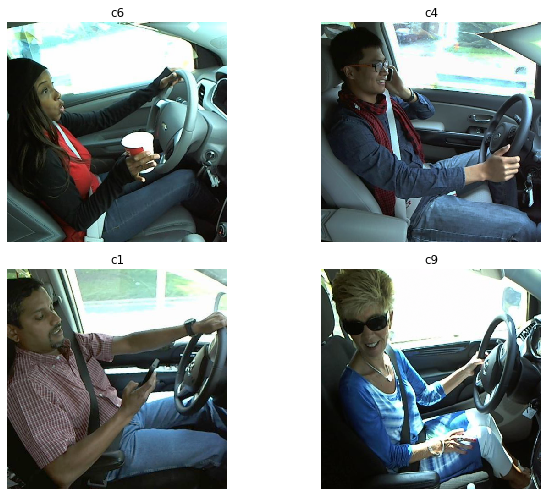

In [8]:
# Log Example images from train set
data.show_batch(2, figsize=(10,7))
driver_exp.log_image('Databunch_train_example', plt.gcf())

In [9]:
learn = cnn_learner(data, CONFIG["model"], metrics=CONFIG["metric"])

if CONFIG["trained_weights"]:
    learn.load(CONFIG["trained_weights"])

if not CONFIG["freeze"]:
    learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


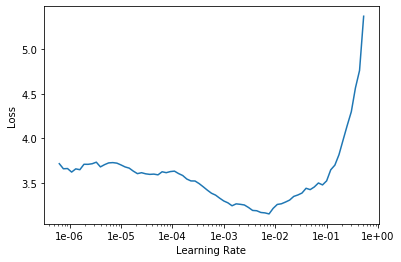

In [10]:
# Plot Learning Rate Finder
learn.lr_find()
learn.recorder.plot()
driver_exp.log_image('Learning Rate Finder Plot', plt.gcf())

In [11]:
max_lr = slice(5e-4,1e-3)
driver_exp.set_property('max_lr', max_lr)
n_cycle = 8
driver_exp.set_property('n_cycle', n_cycle)

Experiment(DDD-23)

In [12]:
learn.callbacks.append(NeptuneMonitor())
learn.fit_one_cycle(n_cycle, max_lr=max_lr, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.377453,0.397513,0.123605,0.876395,12:14
1,0.318083,1.402328,0.327253,0.672747,12:11
2,0.172005,0.740673,0.185193,0.814807,12:16
3,0.131345,0.419350,0.098498,0.901502,12:22
4,0.060162,0.262617,0.073176,0.926824,12:18
5,0.027332,0.336747,0.092275,0.907725,12:19
6,0.012649,0.291177,0.069528,0.930472,12:28
7,0.006408,0.284174,0.068026,0.931974,12:27


In [13]:
driver_exp.append_tag(CONFIG["model"].__name__)
freeze = "freeze" if CONFIG["freeze"] else "unfreeze"
weight_file_name = CONFIG["model"].__name__ + "_" + freeze + "_img_size_" + str(CONFIG["img_size"]) + "_" + driver_exp.id
learn.save(weight_file_name)
driver_exp.log_artifact(Path("dataset/models/" + weight_file_name + ".pth"))

In [14]:
driver_exp.stop()